Lightcurve 1, burstid: 1520120613
Initializing...


QPP_Funcs.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
QPP_Funcs.py:25: RuntimeWarning: divide by zero encountered in divide
  dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
QPP_Funcs.py:25: RuntimeWarning: invalid value encountered in multiply
  dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)


Initial log-parameters:[  0.           0.           0.           0.           0.          11.85334682
   6.93095654   7.62410372]
Optimizing...
Initial log-likelihood: -33044746.986
[  0.           0.           0.           0.           0.          11.85334682
   6.93095654   7.62410372]
33044746.986
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  nan  nan  nan  nan  nan  nan  nan]
nan
[ nan  n

QPP_Funcs.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(probA * probtau1 * probtau2 * np.e)
QPP_Funcs.py:60: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
QPP_Funcs.py:75: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_a*prob_c * np.e)


Sampling...


QPP_Funcs.py:18: RuntimeWarning: overflow encountered in exp
  lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
QPP_Funcs.py:19: RuntimeWarning: invalid value encountered in multiply
  return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
QPP_Funcs.py:19: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))


Done!
Plotting...
[  9.69995268   1.29861674  19.70007799  14.96483952   1.31010661
  11.86597055   8.72446091   8.81000744]


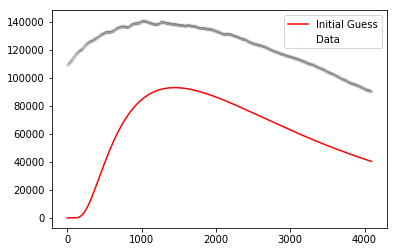

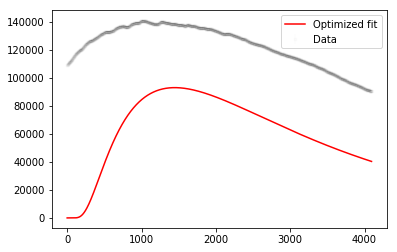

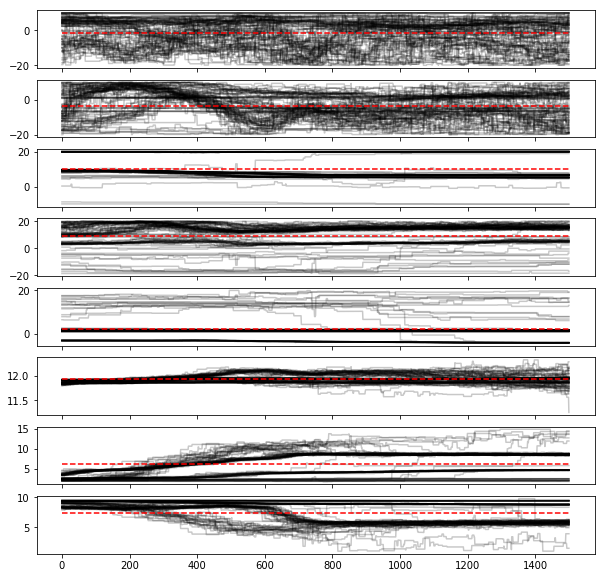

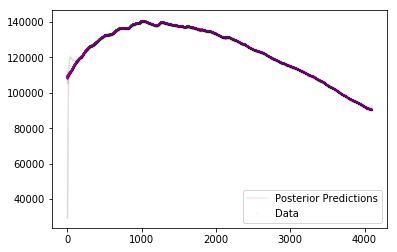

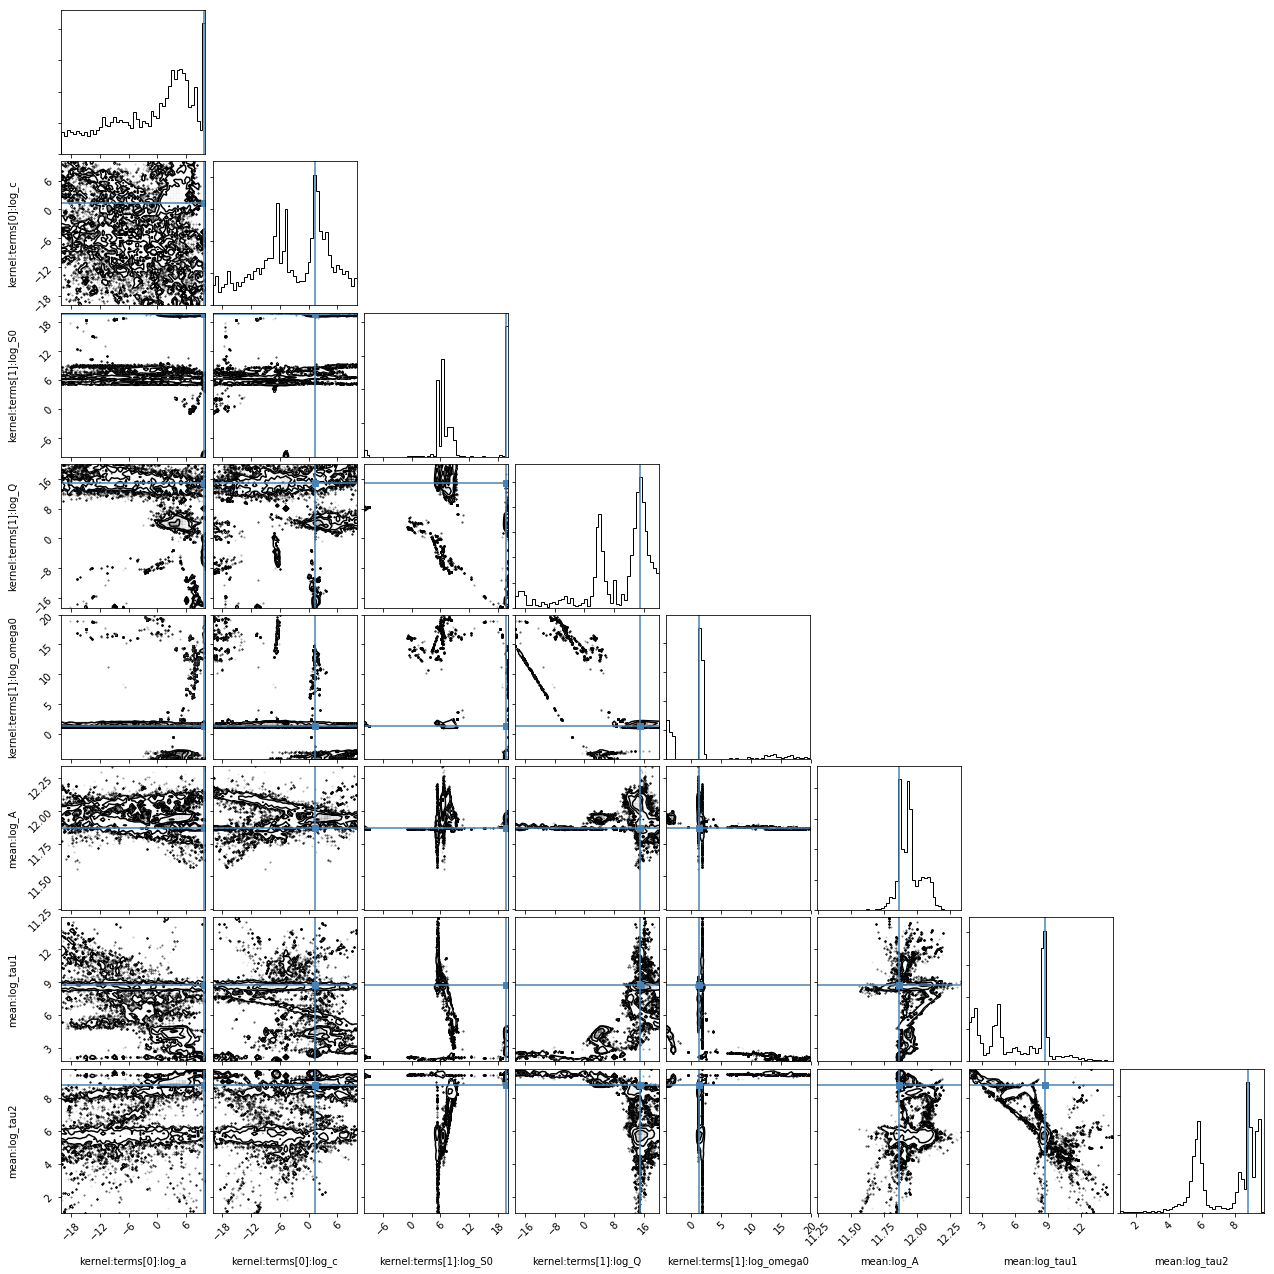

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import celerite as ce
import emcee as mc
import QPP_Funcs as qpp
import corner
from celerite.modeling import Model
from scipy.optimize import minimize, curve_fit

i=0
plots = []
corners = []
datadir = "/Users/chris/Documents/QPP/SolarFlareGPs/data/daniela_goes_data/"

#for burstid in range(1520110128,1520170715):
while (i<1):
    burstid = np.random.randint(1520110128,1520170715)
    try:
        time, flux = qpp.load_data(datadir,burstid)
    except(IOError):
        pass
    else:
        i+=1
        tt,ft = qpp.trim_data(time,flux)
        ft = ft*1e10  #cheating conversions!!!
        ft_err = np.sqrt(ft)
        print("Lightcurve " + str(i) + ", burstid: " + str(burstid))
        print("Initializing...")
        
        #initialization block
        A_guess, t1_guess, t2_guess = qpp.initguess(tt,ft)
        model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess))
        kernel1 = qpp.SHOTerm_Prior(log_S0 = 0, log_Q = 0, log_omega0 = 0) #write guesser for kernel parameters
        kernel2 = qpp.RealTerm_Prior(log_a=0., log_c=0.) #write guesser for kernel parameters
        kernel = kernel2 + kernel1
        gp = ce.GP(kernel, mean=model, fit_mean=True)
        gp.compute(tt, ft_err)
        figinit = qpp.plot_gp(tt,ft, ft_err, gp, model, predict=True, label="Initial Guess")
        print("Initial log-parameters:" + str(gp.get_parameter_vector()))
        print("Optimizing...")
        
        #optimization
        soln = qpp.optimize_gp(gp, ft)
        gp.set_parameter_vector(soln.x)
        figopt = qpp.plot_gp(tt, ft, ft_err, gp, model, predict=True, label = "Optimized fit")
    
        
        #sampling
        sampler = qpp.sample_gp(soln.x, ft, gp, burnin=1500, nwalkers=100, nsteps = 1500)
        chain = sampler.chain
        print("Plotting...")
        figsam = qpp.plot_chain(chain)
        
        figoptsam = qpp.plot_gp(tt, ft, ft_err, gp, model, chain=chain)
        
        figcorner, maxparams = qpp.plot_corner(chain, labels = gp.get_parameter_names())
        print maxparams
        plots.append(figoptsam)
        corners.append(figcorner)
plt.show()